In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

# Define the skewed Bernoulli map and its derivative
def f_SB(x, b):
    return np.where(x <= 1/b, b * x, (b * x - 1) / (b - 1))

def df_SB(x, b):
    return np.where(x <= 1/b, b, b / (b - 1))

In [ ]:


def simulate_y_trajectories(N=100, T=1000, epsilon=0.3, b=4.0):
    y = np.random.rand(N)
    y_history = np.zeros((T, N))

    for t in range(T):
        y_mean = np.mean(y)
        input_y = (1 - epsilon) * y + epsilon * y_mean
        y = f_SB(input_y, b)
        y_history[t] = y

    return y_history

def compute_synchrony_r(y_history):
    return np.abs(np.mean(np.exp(2j * np.pi * y_history), axis=1))

def sweep_synchrony(epsilon_list, N=100, T=1000, b=4.0):
    num_eps = len(epsilon_list)
    ncols = 5
    nrows = int(np.ceil(num_eps / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 2.5), sharey=True)
    axes = axes.flatten()

    for idx, epsilon in enumerate(epsilon_list):
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=epsilon, b=b)
        r_vals = compute_synchrony_r(y_hist)

        ax = axes[idx]
        ax.plot(r_vals, color='blue')
        ax.set_title(f"ε = {epsilon:.4f}")
        ax.set_xlabel("t")
        if idx % ncols == 0:
            ax.set_ylabel("r(t)")
        ax.grid(True)

    # Hide any unused subplots
    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.suptitle("Synchrony r(t) over different ε values", y=1.02, fontsize=16)
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
from scipy.ndimage import uniform_filter1d

# moving-average smoother
def smooth(x, window=21):
    if window <= 1:
        return x
    return uniform_filter1d(x, size=window, mode='reflect')

# compute summary stats for a single r(t)
def r_stats(r, burn=100):
    # ignore initial transient
    r_post = r[burn:]
    return {
        'r_mean': np.mean(r_post),
        'r_median': np.median(r_post),
        'r_std': np.std(r_post),
        'r_max': np.max(r_post),
        'r_min': np.min(r_post),
        'r_q25': np.percentile(r_post, 25),
        'r_q75': np.percentile(r_post, 75)
    }

# percent of time r exceeds a threshold (useful to quantify bursts)
def percent_time_above(r, thresh=0.2, burn=100):
    r_post = r[burn:]
    return np.mean(r_post > thresh)

# ensemble average: run multiple seeds and average r(t)
def ensemble_r(epsilon, N=100, T=1000, b=4.0, trials=10, seed0=0):
    all_r = []
    for tr in range(trials):
        np.random.seed(seed0 + tr)
        y_hist = simulate_y_trajectories(N=N, T=T, epsilon=epsilon, b=b)
        r = compute_synchrony_r(y_hist)
        all_r.append(r)
    all_r = np.array(all_r)  # shape (trials, T)
    return all_r.mean(axis=0), all_r.std(axis=0)

# compute PSD for r(t) (useful to see dominant timescales)
def r_psd(r, fs=1.0):
    f, Pxx = welch(r, fs=fs, nperseg=min(256, len(r)))
    return f, Pxx


In [ ]:
import pandas as pd

def sweep_analyze(epsilon_list, N=100, T=1000, b=4.0,
                  trials=5, smooth_win=21, burn=100, thresh=0.2):
    # store results
    rows = []
    r_matrix = []  # for heatmap: average across trials r(t)

    for eps in epsilon_list:
        r_mean_t, r_std_t = ensemble_r(eps, N=N, T=T, b=b, trials=trials)
        r_smooth = smooth(r_mean_t, window=smooth_win)
        r_matrix.append(r_smooth)
        stats = r_stats(r_smooth, burn=burn)
        pct = percent_time_above(r_smooth, thresh=thresh, burn=burn)
        stats.update({
            'epsilon': eps,
            'pct_above_thresh': pct,
            'r_time_series_mean': np.mean(r_smooth),
        })
        rows.append(stats)

    df = pd.DataFrame(rows).set_index('epsilon')
    r_matrix = np.array(r_matrix)  # shape (len(epsilon_list), T)
    return df, r_matrix


In [ ]:
def plot_heatmap(r_matrix, epsilon_list, t_range=None, cmap='viridis'):
    # r_matrix shape: (num_eps, T)
    plt.figure(figsize=(10, 6))
    if t_range is None:
        im = plt.imshow(r_matrix, aspect='auto', origin='lower',
                        extent=[0, r_matrix.shape[1], epsilon_list[0], epsilon_list[-1]],
                        cmap=cmap)
    else:
        t0, t1 = t_range
        im = plt.imshow(r_matrix[:, t0:t1], aspect='auto', origin='lower',
                        extent=[t0, t1, epsilon_list[0], epsilon_list[-1]],
                        cmap=cmap)
    plt.colorbar(im, label='r(t) (smoothed)')
    plt.ylabel('epsilon')
    plt.xlabel('time')
    plt.title('Heatmap: r(t) (rows = eps values)')
    plt.show()

def plot_mean_vs_eps(df):
    plt.figure(figsize=(8,4))
    plt.errorbar(df.index, df['r_time_series_mean'], yerr=df['r_std'], fmt='-o', capsize=3)
    plt.xlabel('epsilon')
    plt.ylabel('mean r (smoothed)')
    plt.title('Mean Synchrony vs Epsilon')
    plt.grid(True)
    plt.show()

def plot_example_rts(epsilon_list, r_matrix, eps_to_plot=[0.0, 0.08, 0.2, 0.4], burn=100):
    plt.figure(figsize=(10,6))
    for eps in eps_to_plot:
        ix = np.argmin(np.abs(np.array(epsilon_list) - eps))
        r = r_matrix[ix]
        plt.plot(r, label=f'eps={epsilon_list[ix]:.4f}', alpha=0.9)
    plt.axvline(burn, color='k', ls='--', lw=0.6)
    plt.xlabel('time')
    plt.ylabel('r(t) (smoothed)')
    plt.legend()
    plt.title('Example r(t) traces at selected epsilons')
    plt.show()


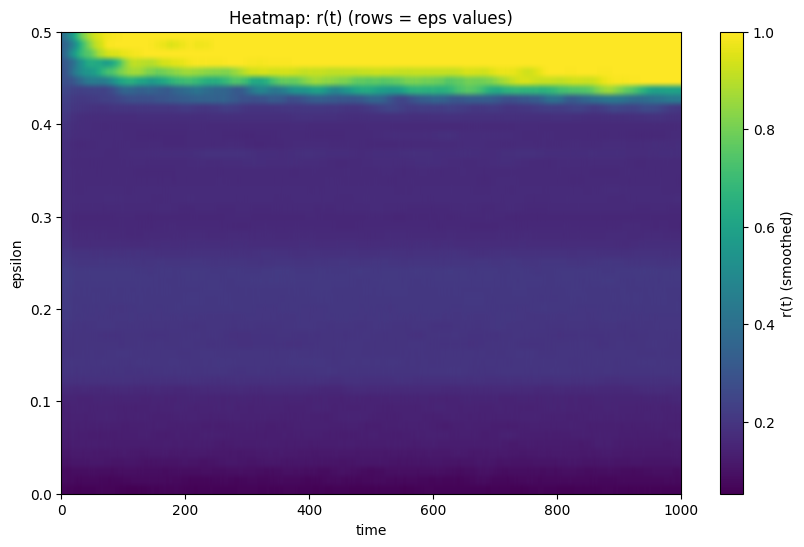

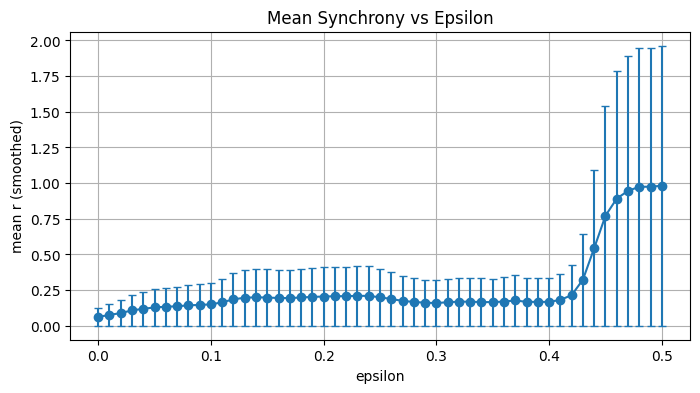

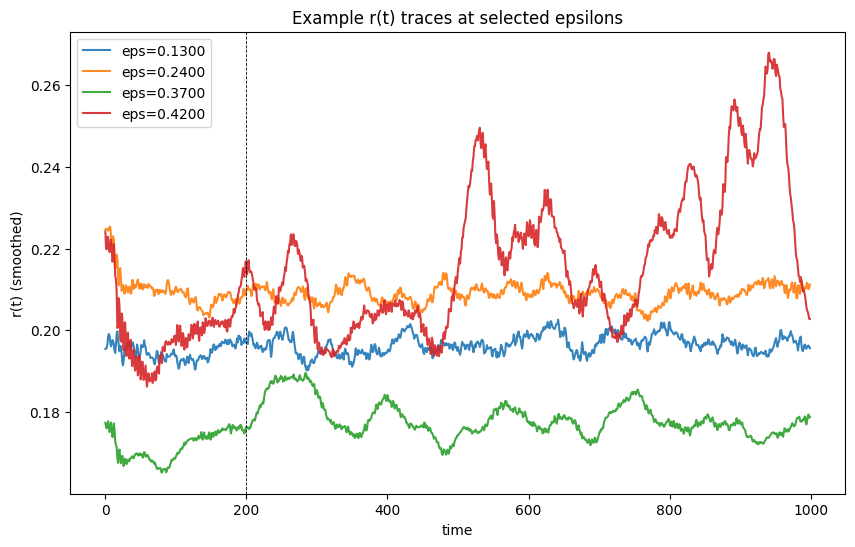

         r_time_series_mean     r_std  pct_above_thresh
epsilon                                                
0.00               0.061861  0.061861               0.0
0.01               0.075552  0.075552               0.0
0.02               0.088731  0.088731               0.0
0.03               0.107508  0.107508               0.0
0.04               0.118692  0.118692               0.0
0.05               0.128149  0.128149               0.0
0.06               0.133305  0.133305               0.0
0.07               0.136256  0.136256               0.0
0.08               0.142990  0.142990               0.0
0.09               0.145937  0.145937               0.0
           r_mean  r_median     r_std     r_max     r_min     r_q25     r_q75  \
epsilon                                                                         
0.50     1.000000  1.000000  0.981534  1.000000  1.000000  1.000000  1.000000   
0.49     0.999077  1.000000  0.974502  1.000000  0.978496  1.000000  1.000000   
0.48

In [ ]:

epsilon_list = np.linspace(0, 0.5, 51)  # every 0.01
df, r_matrix = sweep_analyze(epsilon_list, N=200, T=1000, b=4.0,
                             trials=8, smooth_win=31, burn=200, thresh=0.2)

# 1) heatmap to spot regimes
plot_heatmap(r_matrix, epsilon_list)

# 2) mean vs epsilon (with std from ensemble)
# add r_std column to df: compute per-eps std (time-averaged across t) if desired
df['r_std'] = r_matrix.mean(axis=1)  # (or better compute across trials in sweep_analyze)
plot_mean_vs_eps(df)

# 3) example traces for a few eps where peaks occur
plot_example_rts(epsilon_list, r_matrix, eps_to_plot=[0.1313,0.2373, 0.3686, 0.4242], burn=200)

# 4) find candidate eps where mean r or pct_above_thresh changes abruptly
print(df[['r_time_series_mean','r_std','pct_above_thresh']].head(10))
# sort by mean r to see highest synchrony regions
print(df.sort_values('r_time_series_mean', ascending=False).head(10))


In [ ]:
def sweep_and_plot2(
    epsilon_list,
    N=100,
    T=1000,
    b=4.0,
    burn=100,
    eps_to_plot=None,
    trials=10,
    smooth_win=21
):
    r_matrix = []

    # Run ensemble simulations for each epsilon
    for eps in epsilon_list:
        r_mean_t, r_std_t = ensemble_r(eps, N=N, T=T, b=b, trials=trials)
        r_smooth = smooth(r_mean_t, window=smooth_win)
        r_matrix.append(r_smooth)

    if eps_to_plot is None:
        eps_to_plot = epsilon_list

    plt.figure(figsize=(10, 6))
    for eps in eps_to_plot:
        idx = epsilon_list.index(eps)  # exact match
        plt.plot(r_matrix[idx], label=f'eps={eps:.4f}')

    plt.axvline(burn, color='k', ls='--', lw=0.6)
    plt.xlabel('time')
    plt.ylabel('r(t) (smoothed)')
    plt.legend()
    plt.title('Smoothed synchrony r(t) for different epsilon values')
    plt.show()

    return np.array(r_matrix)


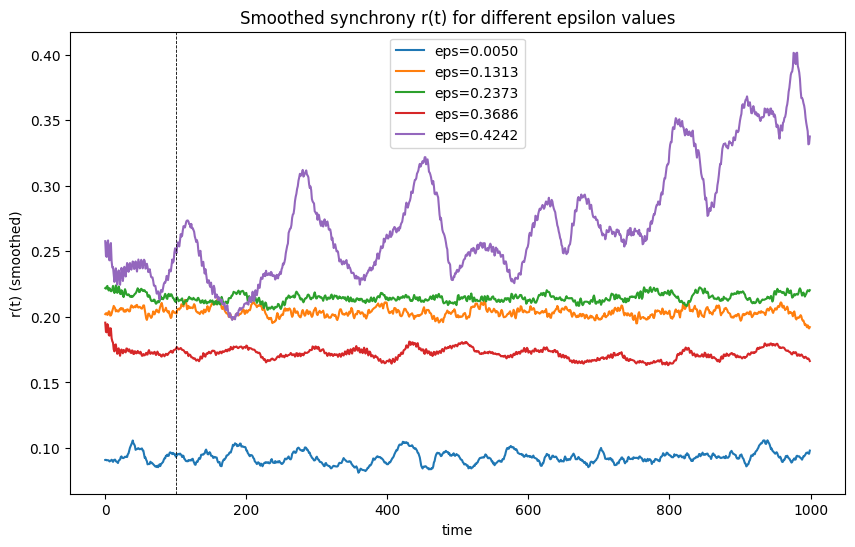

In [ ]:
epsilon_list = [0.0050, 0.1313,0.2373, 0.3686, 0.4242]
r_matrix = sweep_and_plot2(epsilon_list, N=100, T=1000, b=4.0, burn=100, eps_to_plot=None)

In [ ]:

def plot_mean_vs_eps_with_special_points(
    df_smooth,               # DataFrame for smooth sweep
    df_special,              # DataFrame for special points
):
    plt.figure(figsize=(10,5))

    # Plot smooth sweep (51 points)
    plt.errorbar(
        df_smooth.index,
        df_smooth['r_time_series_mean'],
        yerr=df_smooth['r_std'],
        fmt='-o', capsize=3, label='Smooth sweep (51 points)', color='blue', alpha=0.7
    )

    # Plot special epsilons distinctly
    plt.errorbar(
        df_special.index,
        df_special['r_time_series_mean'],
        yerr=df_special['r_std'],
        fmt='s', capsize=5, label='Peak epsilons', color='red',
        markersize=4, markeredgewidth=1.5, markeredgecolor='black'
    )

    plt.xlabel('Epsilon')
    plt.ylabel('Mean r (smoothed)')
    plt.title('Mean Synchrony vs Epsilon')
    plt.grid(True)
    plt.legend()
    plt.show()

# === Parameters ===
N = 100
T = 1000
b = 4.0
trials = 5
smooth_win = 21
burn = 100
thresh = 0.2

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set academic style
sns.set(style="whitegrid", context="talk")  # larger fonts, clean grid
import matplotlib.pyplot as plt
import seaborn as sns

# Academic style
sns.set(style="whitegrid", context="talk")

def plot_mean_vs_eps_with_special_points_aesthetic(
    df_smooth,        # DataFrame for smooth sweep
    df_special,       # DataFrame for special points
    blue_marker_size=6,   # size of smooth sweep markers
    red_marker_size=8,    # size of special points
    pdf_filename="mean_vs_epsilon.pdf"
):
    plt.figure(figsize=(12,6))

    # Smooth sweep line
    plt.errorbar(
        df_smooth.index,
        df_smooth['r_time_series_mean'],
        yerr=df_smooth['r_std'],
        fmt='o-',
        capsize=4,
        label='r',
        color='blue',
        markersize=blue_marker_size,
        linewidth=2,
        alpha=0.7
    )

    # Special points
    plt.errorbar(
        df_special.index,
        df_special['r_time_series_mean'],
        yerr=df_special['r_std'],
        fmt='s',
        capsize=5,
        label='Peak epsilons',
        color='red',
        markersize=red_marker_size,
        markeredgewidth=1.5,
        markeredgecolor='black',
        linewidth=2
    )

    # Labels with LaTeX formatting
    plt.xlabel(r'$\epsilon$', fontsize=16)
    plt.ylabel(r'Time-averaged $r$', fontsize=16)
    #plt.title('Mean Synchrony vs Epsilon', fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Save PDF
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", dpi=300)
    plt.show()


In [ ]:



# Smooth sweep: 51 points from 0 to 0.5
epsilon_smooth = np.linspace(0, 0.5, 51)
df_smooth, _ = sweep_analyze(epsilon_smooth, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Special epsilons (given)
epsilon_special = [0.0050, 0.1313, 0.2373, 0.3686, 0.4242]
df_special, _ = sweep_analyze(epsilon_special, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Plot both sets together
plot_mean_vs_eps_with_special_points(df_smooth, df_special)


KeyboardInterrupt: 

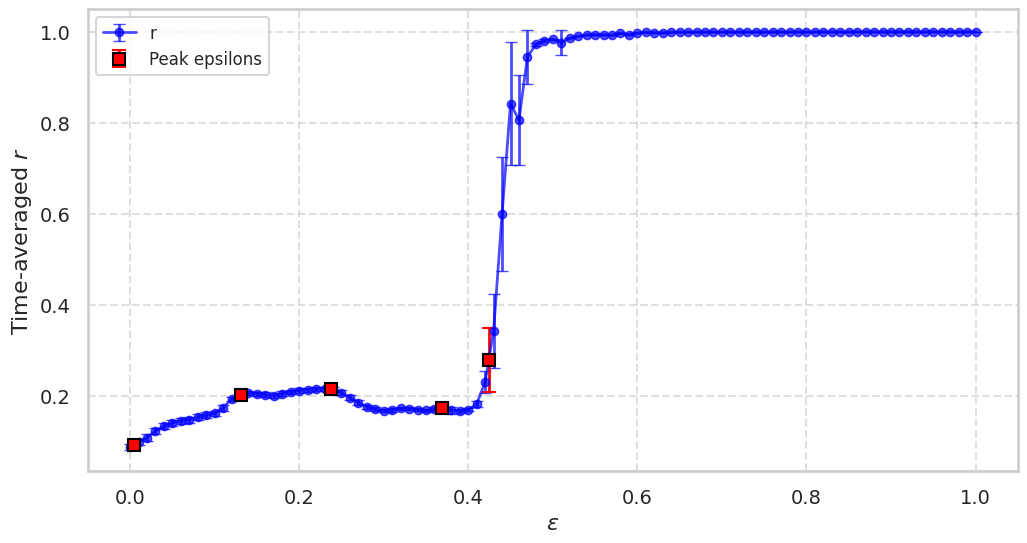

In [ ]:
N = 100
epsilon_smooth = np.linspace(0, 1, 101)

df_smooth, _ = sweep_analyze(epsilon_smooth, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Special epsilons (given)
epsilon_special = [0.0050, 0.1313, 0.2373, 0.3686, 0.4242]
df_special, _ = sweep_analyze(epsilon_special, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Plot both sets together
plot_mean_vs_eps_with_special_points_aesthetic(df_smooth, df_special)

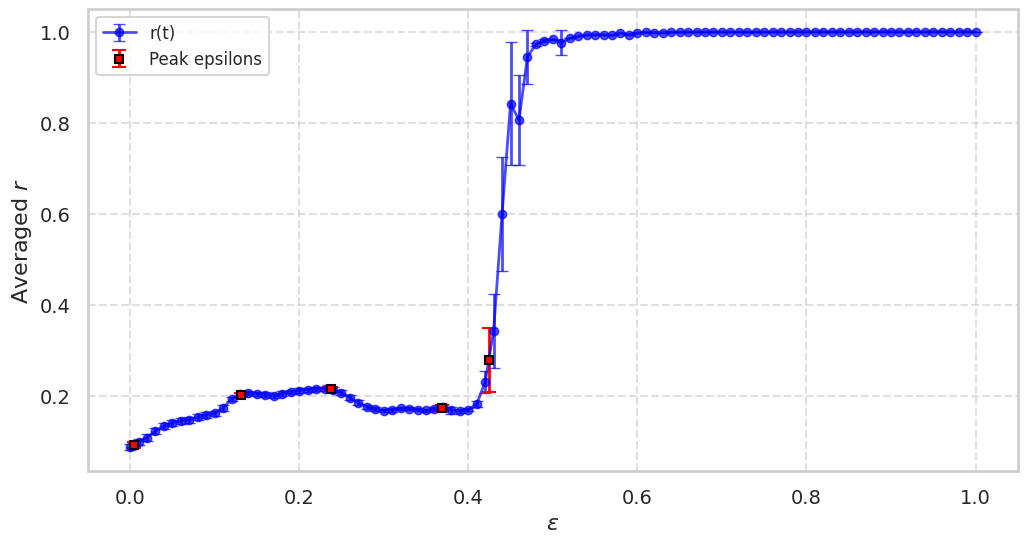

In [ ]:
plot_mean_vs_eps_with_special_points_aesthetic(
    df_smooth,
    df_special,
    blue_marker_size=6,
    red_marker_size=6
)


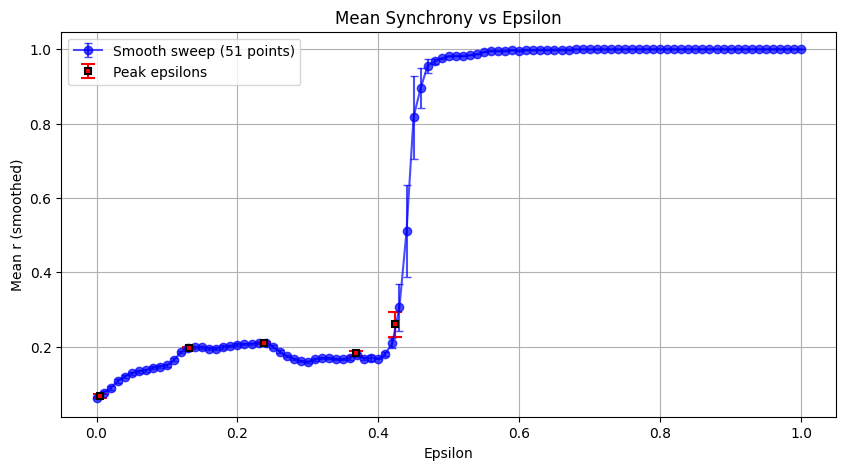

In [ ]:
N = 200
epsilon_smooth = np.linspace(0, 1, 101)

df_smooth, _ = sweep_analyze(epsilon_smooth, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Special epsilons (given)
epsilon_special = [0.0050, 0.1313, 0.2373, 0.3686, 0.4242]
df_special, _ = sweep_analyze(epsilon_special, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Plot both sets together
plot_mean_vs_eps_with_special_points(df_smooth, df_special)

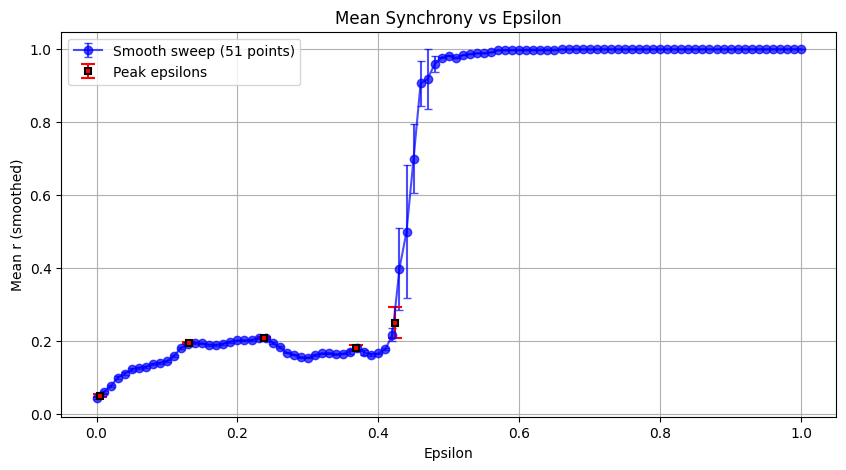

In [ ]:
N = 400
epsilon_smooth = np.linspace(0, 1, 101)

df_smooth, _ = sweep_analyze(epsilon_smooth, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Special epsilons (given)
epsilon_special = [0.0050, 0.1313, 0.2373, 0.3686, 0.4242]
df_special, _ = sweep_analyze(epsilon_special, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Plot both sets together
plot_mean_vs_eps_with_special_points(df_smooth, df_special)

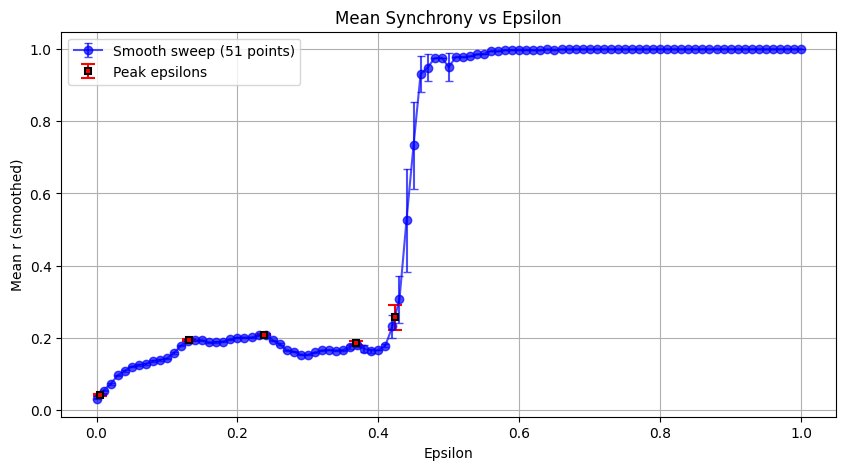

In [ ]:
N = 800
epsilon_smooth = np.linspace(0, 1, 101)

df_smooth, _ = sweep_analyze(epsilon_smooth, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Special epsilons (given)
epsilon_special = [0.0050, 0.1313, 0.2373, 0.3686, 0.4242]
df_special, _ = sweep_analyze(epsilon_special, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Plot both sets together
plot_mean_vs_eps_with_special_points(df_smooth, df_special)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set(style="whitegrid", context="talk")  # academic aesthetics

# ----- Function 1: Compute sweeps for multiple N -----
def compute_sweeps_multiple_N(N_list, epsilon_smooth, epsilon_special, T=1000, b=4.0,
                              trials=5, smooth_win=5, burn=200, thresh=1e-6):
    """
    Compute smooth sweeps and special points for multiple N values.

    Returns:
        results_dict: dict of N -> {'df_smooth': ..., 'df_special': ...}
    """
    results_dict = {}
    for N in N_list:
        df_smooth, _ = sweep_analyze(
            epsilon_smooth, N=N, T=T, b=b,
            trials=trials, smooth_win=smooth_win,
            burn=burn, thresh=thresh
        )
        df_special, _ = sweep_analyze(
            epsilon_special, N=N, T=T, b=b,
            trials=trials, smooth_win=smooth_win,
            burn=burn, thresh=thresh
        )
        results_dict[N] = {'df_smooth': df_smooth, 'df_special': df_special}
    return results_dict




In [ ]:

# ----- Function 2: Plot sweeps with special points -----
def plot_sweeps_multiple_N(results_dict, pdf_filename="mean_vs_epsilon_multiple_N_special.pdf",
                            line_width=2, markersize=4, special_marker_size=4):
    """
    Plot smooth sweeps and special points for multiple N.
    """
    plt.figure(figsize=(12,6))

    for N, data in results_dict.items():
        df_smooth = data['df_smooth']
        df_special = data['df_special']

        # Smooth sweep
        plt.errorbar(
            df_smooth.index,
            df_smooth['r_time_series_mean'],
            yerr=df_smooth['r_std'],
            fmt='-o',
            capsize=4,
            label=f'N = {N}',
            linewidth=line_width,
            markersize=markersize,
            alpha=0.8
        )

        # Special points
        plt.errorbar(
            df_special.index,
            df_special['r_time_series_mean'],
            yerr=df_special['r_std'],
            fmt='s',
            capsize=5,
            color='red',
            markeredgecolor='black',
            markeredgewidth=1.5,
            markersize=special_marker_size,
            linewidth=line_width,
            alpha=1
        )

    # Labels, title, grid
    plt.xlabel(r'$\epsilon$', fontsize=16)
    plt.ylabel(r'Averaged $r$', fontsize=16)
    #plt.title('Mean Synchrony vs Epsilon for Different $N$', fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Save PDF
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

In [ ]:
N_list = [100, 400, 800, 1600, 3200]
epsilon_smooth = np.linspace(0, 1, 101)
epsilon_special = [0.0050, 0.1313, 0.2373, 0.3686, 0.4242]

# Step 1: Compute all sweeps
results_dict = compute_sweeps_multiple_N(
    N_list, epsilon_smooth, epsilon_special,
    T=T, b=b, trials=trials,
    smooth_win=smooth_win, burn=burn, thresh=thresh
)



In [ ]:
def plot_sweeps_multiple_N(results_dict, pdf_filename="mean_vs_epsilon_multiple_N_special.pdf",
                            line_width=2, markersize=4, special_marker_size=4):
    """
    Plot smooth sweeps and special points for multiple N.
    No error bars, just connected points.
    """
    plt.figure(figsize=(12,6))

    for N, data in results_dict.items():
        df_smooth = data['df_smooth']
        df_special = data['df_special']

        # Smooth sweep (lines with markers)
        plt.plot(
            df_smooth.index,
            df_smooth['r_time_series_mean'],
            '-o',
            label=f'N = {N}',
            linewidth=line_width,
            markersize=markersize,
            alpha=0.8
        )

        # Special points (red squares, no error bars)
        plt.plot(
            df_special.index,
            df_special['r_time_series_mean'],
            's',
            color='red',
            markeredgecolor='black',
            markeredgewidth=1.5,
            markersize=special_marker_size,
            linewidth=line_width,
            alpha=1
        )

    # Labels, grid, legend
    plt.xlabel(r'$\epsilon$', fontsize=16)
    plt.ylabel(r'Averaged $r$', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Save PDF
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", dpi=300)
    plt.show()


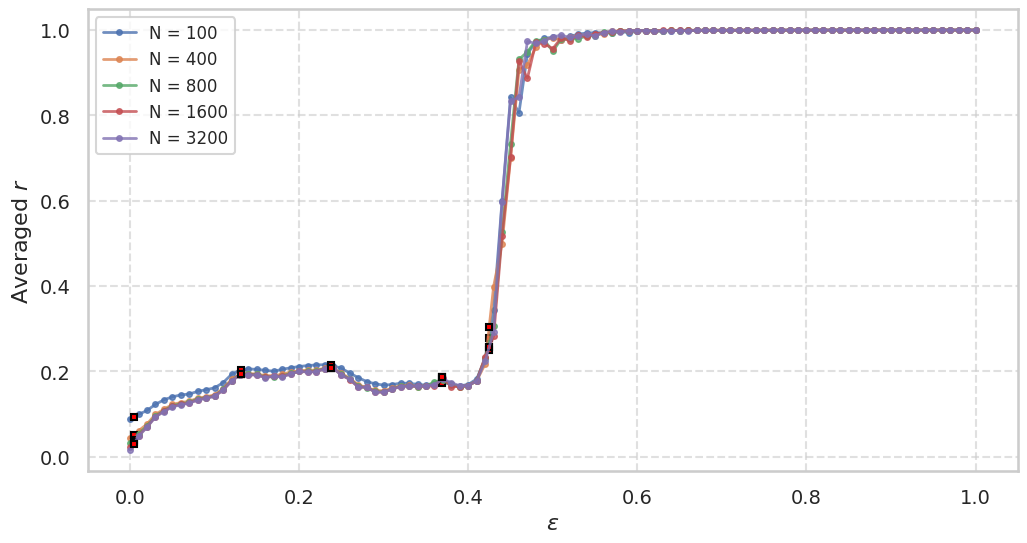

In [ ]:
# Step 2: Plot with aesthetics and save PDF
plot_sweeps_multiple_N(results_dict)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sweeps_multiple_N(results_dict, pdf_filename="mean_vs_epsilon_multiple_N_special.pdf",
                            line_width=1.5, markersize=4, special_marker_size=6):
    """
    Plot smooth sweeps and special points for multiple N with improved visibility.
    Uses Tab10 colors and distinct markers.
    """
    plt.figure(figsize=(12,6))

    # Prepare colors and markers
    N_count = len(results_dict)
    tab10 = plt.get_cmap('tab10')
    colors = [tab10(i % 10) for i in range(N_count)]
    markers = ['o', 's', '^', 'v', 'D', '*', 'P', 'X', 'h', 'd']  # extend if needed

    for (N, data), color, marker in zip(results_dict.items(), colors, markers):
        df_smooth = data['df_smooth']
        df_special = data['df_special']

        # Smooth sweep (lines with markers)
        plt.plot(
            df_smooth.index,
            df_smooth['r_time_series_mean'],
            '-'+marker,
            label=f'N = {N}',
            color=color,
            linewidth=line_width,
            markersize=markersize,
            alpha=0.8
        )

        # Special points (always red squares on top)
        plt.plot(
            df_special.index,
            df_special['r_time_series_mean'],
            's',
            color='red',
            markeredgecolor='black',
            markeredgewidth=1.5,
            markersize=special_marker_size,
            linewidth=line_width,
            alpha=1
        )

    # Labels, grid, legend
    plt.xlabel(r'$\epsilon$', fontsize=16)
    plt.ylabel(r'Time-averaged R', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12, ncol=2)  # 2 columns for readability

    # Save PDF
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", dpi=300)
    plt.show()


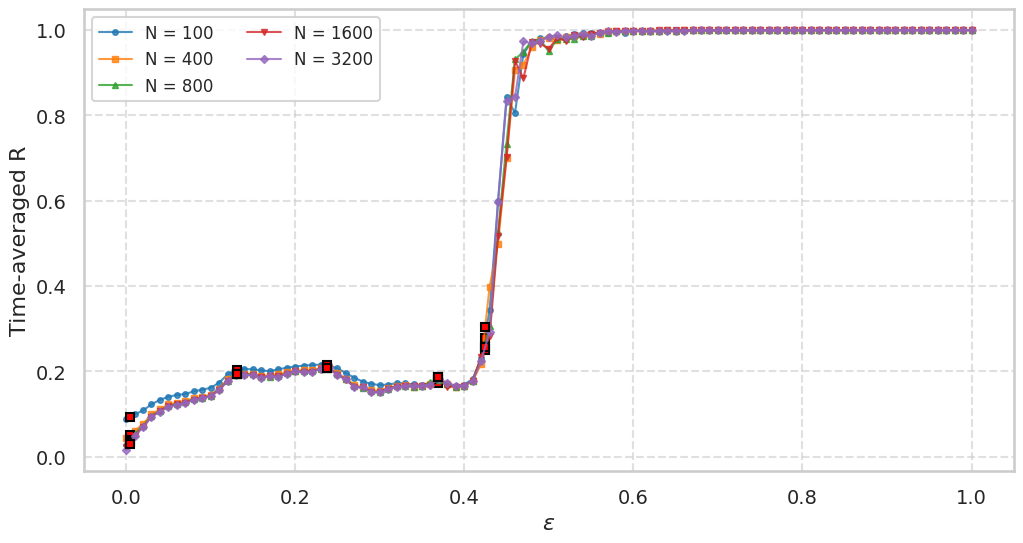

In [ ]:
# Step 2: Plot with aesthetics and save PDF
plot_sweeps_multiple_N(results_dict)

In [ ]:
epsilon_smooth = np.linspace(0, 1, 101)
df_smooth, _ = sweep_analyze(epsilon_smooth, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Special epsilons (given)
epsilon_special = [0.0050, 0.1313, 0.2373, 0.3686, 0.4242]
df_special, _ = sweep_analyze(epsilon_special, N=N, T=T, b=b, trials=trials, smooth_win=smooth_win, burn=burn, thresh=thresh)

# Plot both sets together
plot_mean_vs_eps_with_special_points(df_smooth, df_special)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Academic style
sns.set(style="whitegrid", context="talk")

def plot_mean_vs_eps_multiple_N_with_special(
    N_list,               # list of N values
    epsilon_smooth,       # array of epsilon values
    epsilon_special,      # list/array of special epsilon points
    T=1000,
    b=4.0,
    trials=5,
    smooth_win=5,
    burn=200,
    thresh=1e-6,
    pdf_filename="mean_vs_epsilon_multiple_N_special.pdf",
    line_width=2,
    markersize=6,
    special_marker_size=8
):
    plt.figure(figsize=(12,6))

    for N in N_list:
        # Smooth sweep
        df_smooth, _ = sweep_analyze(
            epsilon_smooth, N=N, T=T, b=b,
            trials=trials, smooth_win=smooth_win,
            burn=burn, thresh=thresh
        )
        plt.errorbar(
            df_smooth.index,
            df_smooth['r_time_series_mean'],
            yerr=df_smooth['r_std'],
            fmt='-o',
            capsize=4,
            label=f'N = {N}',
            linewidth=line_width,
            markersize=markersize,
            alpha=0.8
        )

        # Special points
        df_special, _ = sweep_analyze(
            epsilon_special, N=N, T=T, b=b,
            trials=trials, smooth_win=smooth_win,
            burn=burn, thresh=thresh
        )
        plt.errorbar(
            df_special.index,
            df_special['r_time_series_mean'],
            yerr=df_special['r_std'],
            fmt='s',
            capsize=5,
            color='red',
            markeredgecolor='black',
            markeredgewidth=1.5,
            markersize=special_marker_size,
            linewidth=line_width,
            alpha=1
        )

    # Labels and title
    plt.xlabel(r'$\epsilon$', fontsize=16)
    plt.ylabel(r'Averaged $r$', fontsize=16)
    plt.title('Mean Synchrony vs Epsilon for Different $N$', fontsize=18)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)

    # Save figure as PDF
    plt.savefig(pdf_filename, format="pdf", bbox_inches="tight", dpi=300)
    plt.show()


In [ ]:
import numpy as np

def parse_log_and_save_npz(log_filename, save_filename="synchrony_data.npz"):
    eps_set = set()
    p_set = set()
    records = []

    # Read the log file line by line
    with open(log_filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith("Done"):
                # Example line: "Done p=0.000, eps=0.000, mean r=0.0906"
                parts = line.split(',')
                p_val = float(parts[0].split('p=')[1])
                eps_val = float(parts[1].split('eps=')[1])
                r_mean = float(parts[2].split('mean r=')[1])

                eps_set.add(eps_val)
                p_set.add(p_val)
                records.append((p_val, eps_val, r_mean))

    # Sort the unique eps and p values
    epsilon_vals = np.array(sorted(eps_set))
    p_vals = np.array(sorted(p_set))

    # Create empty Z matrix: rows = len(p_vals), cols = len(epsilon_vals)
    Z = np.zeros((len(p_vals), len(epsilon_vals)))

    # Fill Z by matching p and eps indices
    p_idx_map = {v: i for i, v in enumerate(p_vals)}
    eps_idx_map = {v: i for i, v in enumerate(epsilon_vals)}

    for p_val, eps_val, r_mean in records:
        i = p_idx_map[p_val]
        j = eps_idx_map[eps_val]
        Z[i, j] = r_mean

    # Save as npz
    np.savez(save_filename, Z=Z, epsilon_vals=epsilon_vals, p_vals=p_vals)
    print(f"Data saved to {save_filename}")

# Usage:
parse_log_and_save_npz("sync.txt")


Data saved to synchrony_data.npz


In [ ]:
import numpy as np
import plotly.express as px

def plot_from_npz(filename="synchrony_data.npz"):
    data = np.load(filename)
    Z = data['Z']
    epsilon_vals = data['epsilon_vals']
    p_vals = data['p_vals']

    fig = px.imshow(
        Z,
        x=np.round(epsilon_vals, 3),
        y=np.round(p_vals, 3),
        labels={'x': 'Epsilon', 'y': 'Connection Probability p', 'color': 'Mean Synchrony'},
        aspect='auto',
        title='Mean Synchrony vs Epsilon and Connection Probability p'
    )
    # Flip y axis so p=0 at bottom
    fig.update_layout(yaxis=dict(autorange='reversed'))
    fig.show()


plot_from_npz("synchrony_data.npz")


In [ ]:
import numpy as np
import plotly.graph_objects as go

def plot_multiple_fixed_eps(filename, epsilons_to_plot):
    data = np.load(filename)
    Z = data['Z']
    epsilon_vals = data['epsilon_vals']
    p_vals = data['p_vals']

    fig = go.Figure()
    for eps in epsilons_to_plot:
        eps_idx = (np.abs(epsilon_vals - eps)).argmin()
        y = Z[:, eps_idx]
        fig.add_trace(go.Scatter(
            x=p_vals,
            y=y,
            mode='lines+markers',
            name=f'ε ≈ {epsilon_vals[eps_idx]:.3f}'
        ))

    fig.update_layout(
        title="Mean Synchrony vs p for multiple fixed ε",
        xaxis_title="Connection Probability p",
        yaxis_title="Mean Synchrony",
        hovermode='x unified'
    )
    fig.show()


In [ ]:
def plot_multiple_fixed_ps(filename, ps_to_plot):
    data = np.load(filename)
    Z = data['Z']
    epsilon_vals = data['epsilon_vals']
    p_vals = data['p_vals']

    fig = go.Figure()
    for p in ps_to_plot:
        p_idx = (np.abs(p_vals - p)).argmin()
        y = Z[p_idx, :]
        fig.add_trace(go.Scatter(
            x=epsilon_vals,
            y=y,
            mode='lines+markers',
            name=f'p ≈ {p_vals[p_idx]:.3f}'
        ))

    fig.update_layout(
        title="Mean Synchrony vs ε for multiple fixed p",
        xaxis_title="Epsilon",
        yaxis_title="Mean Synchrony",
        hovermode='x unified'
    )
    fig.show()


In [ ]:
filename = "synchrony_data.npz"

# Plot mean synchrony vs p for these fixed epsilon values:
epsilons_to_plot = [0.0, 0.2, 0.4, 0.6, 0.8]
plot_multiple_fixed_eps(filename, epsilons_to_plot)

# Plot mean synchrony vs epsilon for these fixed p values:
ps_to_plot = [0.0, 0.25, 0.5, 0.75, 1.0]
plot_multiple_fixed_ps(filename, ps_to_plot)

In [ ]:

def interactive_sync_plot(filename):
    data = np.load(filename)
    Z = data['Z']
    epsilon_vals = data['epsilon_vals']
    p_vals = data['p_vals']

    fig = go.Figure()

    # Prepare traces for fixed epsilons (vary p)
    fixed_eps_traces = []
    epsilons_to_plot = epsilon_vals  # or select a subset for speed/clarity
    for eps in epsilons_to_plot:
        eps_idx = (np.abs(epsilon_vals - eps)).argmin()
        y = Z[:, eps_idx]
        fixed_eps_traces.append(go.Scatter(
            x=p_vals,
            y=y,
            mode='lines+markers',
            name=f'ε ≈ {epsilon_vals[eps_idx]:.3f}',
            visible=False,
        ))

    # Prepare traces for fixed ps (vary epsilon)
    fixed_p_traces = []
    ps_to_plot = p_vals  # or subset
    for p in ps_to_plot:
        p_idx = (np.abs(p_vals - p)).argmin()
        y = Z[p_idx, :]
        fixed_p_traces.append(go.Scatter(
            x=epsilon_vals,
            y=y,
            mode='lines+markers',
            name=f'p ≈ {p_vals[p_idx]:.3f}',
            visible=False,
        ))

    # Add all traces to figure
    for trace in fixed_eps_traces + fixed_p_traces:
        fig.add_trace(trace)

    # Build dropdown buttons
    buttons = []

    # Button to show fixed eps lines only
    buttons.append(dict(
        label="Fix ε, vary p",
        method="update",
        args=[{"visible": [True]*len(fixed_eps_traces) + [False]*len(fixed_p_traces)},
              {"title": "Mean Synchrony vs p for fixed ε"}]
    ))

    # Button to show fixed p lines only
    buttons.append(dict(
        label="Fix p, vary ε",
        method="update",
        args=[{"visible": [False]*len(fixed_eps_traces) + [True]*len(fixed_p_traces)},
              {"title": "Mean Synchrony vs ε for fixed p"}]
    ))

    # Optionally, add buttons to show none or all
    buttons.append(dict(
        label="Hide all",
        method="update",
        args=[{"visible": [False]*(len(fixed_eps_traces)+len(fixed_p_traces))},
              {"title": "Mean Synchrony"}]
    ))

    buttons.append(dict(
        label="Show all",
        method="update",
        args=[{"visible": [True]*(len(fixed_eps_traces)+len(fixed_p_traces))},
              {"title": "Mean Synchrony"}]
    ))

    fig.update_layout(
        updatemenus=[dict(
            active=0,
            buttons=buttons,
            x=1.15,
            y=1,
            xanchor='left',
            yanchor='top'
        )],
        xaxis_title="Parameter",
        yaxis_title="Mean Synchrony",
        hovermode='x unified',
        title="Mean Synchrony"
    )

    # Initially show fixed eps lines (you can choose default)
    for i in range(len(fixed_eps_traces)):
        fig.data[i].visible = True

    fig.show()


interactive_sync_plot("synchrony_data.npz")


In [ ]:
import numpy as np
import plotly.graph_objects as go

def interactive_sync_plot_with_selection(filename, max_lines=5):
    data = np.load(filename)
    Z = data['Z']
    epsilon_vals = data['epsilon_vals']
    p_vals = data['p_vals']

    def get_evenly_spaced_indices(length, max_count):
        if length <= max_count:
            return list(range(length))
        else:
            return np.linspace(0, length - 1, max_count, dtype=int).tolist()

    # Indices of fixed lines to show, evenly spaced
    epsilon_indices_to_show = get_evenly_spaced_indices(len(epsilon_vals), max_lines)
    p_indices_to_show = get_evenly_spaced_indices(len(p_vals), max_lines)

    # Prepare all traces:
    traces = []

    # Fixed epsilon traces (vary p)
    for eps in epsilon_vals:
        eps_idx = (np.abs(epsilon_vals - eps)).argmin()
        y = Z[:, eps_idx]
        traces.append(go.Scatter(
            x=p_vals,
            y=y,
            mode='lines+markers',
            name=f'ε ≈ {epsilon_vals[eps_idx]:.3f}',
            visible=eps_idx in epsilon_indices_to_show
        ))

    # Fixed p traces (vary epsilon)
    for p in p_vals:
        p_idx = (np.abs(p_vals - p)).argmin()
        y = Z[p_idx, :]
        traces.append(go.Scatter(
            x=epsilon_vals,
            y=y,
            mode='lines+markers',
            name=f'p ≈ {p_vals[p_idx]:.3f}',
            visible=False  # hide initially; shown only when mode switched
        ))

    fig = go.Figure(data=traces)

    # Buttons to switch between modes
    mode_buttons = [
        dict(
            label="Fix ε, vary p",
            method="update",
            args=[{"visible": [i in epsilon_indices_to_show for i in range(len(epsilon_vals))]
                            + [False]*len(p_vals)},
                  {"title": "Mean Synchrony vs p for fixed ε",
                   "xaxis": {"title": "Connection Probability p"}}]
        ),
        dict(
            label="Fix p, vary ε",
            method="update",
            args=[{"visible": [False]*len(epsilon_vals)
                            + [i in p_indices_to_show for i in range(len(p_vals))]},
                  {"title": "Mean Synchrony vs ε for fixed p",
                   "xaxis": {"title": "Epsilon"}}]
        )
    ]

    # Dropdown buttons to select how many fixed epsilon lines to show
    epsilon_show_buttons = []
    for n in range(1, max_lines + 1):
        indices = epsilon_indices_to_show[:n]
        visible_eps = [i in indices for i in range(len(epsilon_vals))]
        visible_p = [False] * len(p_vals)
        epsilon_show_buttons.append(dict(
            label=f"Show {n} ε lines",
            method="update",
            args=[{"visible": visible_eps + visible_p},
                  {"title": f"Mean Synchrony vs p (fixed ε), showing {n} evenly spaced lines"}]
        ))

    # Dropdown buttons to select how many fixed p lines to show
    p_show_buttons = []
    for n in range(1, max_lines + 1):
        indices = p_indices_to_show[:n]
        visible_eps = [False] * len(epsilon_vals)
        visible_p = [i in indices for i in range(len(p_vals))]
        p_show_buttons.append(dict(
            label=f"Show {n} p lines",
            method="update",
            args=[{"visible": visible_eps + visible_p},
                  {"title": f"Mean Synchrony vs ε (fixed p), showing {n} evenly spaced lines"}]
        ))

    fig.update_layout(
        updatemenus=[
            dict(
                buttons=mode_buttons,
                direction="down",
                showactive=True,
                x=0,
                y=1.15,
                xanchor='left',
                yanchor='top',
                pad={"r": 10, "t": 10},
                bgcolor="lightgray",
                bordercolor="black",
                borderwidth=1,
                font=dict(size=14),
                active=0,
                name="mode_menu"
            ),
            dict(
                buttons=epsilon_show_buttons,
                direction="down",
                showactive=True,
                x=0.3,
                y=1.15,
                xanchor='left',
                yanchor='top',
                pad={"r": 10, "t": 10},
                bgcolor="lightgray",
                bordercolor="black",
                borderwidth=1,
                font=dict(size=14),
                active=max_lines-1,
                name="epsilon_show_menu",
                visible=True
            ),
            dict(
                buttons=p_show_buttons,
                direction="down",
                showactive=True,
                x=0.6,
                y=1.15,
                xanchor='left',
                yanchor='top',
                pad={"r": 10, "t": 10},
                bgcolor="lightgray",
                bordercolor="black",
                borderwidth=1,
                font=dict(size=14),
                active=max_lines-1,
                name="p_show_menu",
                visible=False
            )
        ],
        title="Mean Synchrony vs p for fixed ε",
        xaxis_title="Connection Probability p",
        yaxis_title="Mean Synchrony",
        hovermode='x unified',
        margin=dict(t=100)
    )

    # Show initial fixed epsilon lines only (evenly spaced)
    for i in range(len(epsilon_vals)):
        fig.data[i].visible = (i in epsilon_indices_to_show)
    for i in range(len(epsilon_vals), len(epsilon_vals) + len(p_vals)):
        fig.data[i].visible = False

    fig.show()


In [ ]:
interactive_sync_plot_with_selection("synchrony_data.npz", max_lines=20)


In [ ]:
import numpy as np
import plotly.graph_objects as go

# === Load data ===
data = np.load("synchrony_data.npz")
Z = data["Z"]
epsilon_vals = data["epsilon_vals"]
p_vals = data["p_vals"]

# === Threshold ===
r_threshold = 0.999

# === Compute ε_c(p) ===
eps_c = np.full(len(p_vals), np.nan)
for i, p in enumerate(p_vals):
    idx = np.argmax(Z[i] >= r_threshold)
    if Z[i, idx] >= r_threshold:
        eps_c[i] = epsilon_vals[idx]

# === Compute p_c(ε) ===
p_c = np.full(len(epsilon_vals), np.nan)
for j, eps in enumerate(epsilon_vals):
    idx = np.argmax(Z[:, j] >= r_threshold)
    if Z[idx, j] >= r_threshold:
        p_c[j] = p_vals[idx]

# === Heatmap with phase boundary ===
fig1 = go.Figure()

fig1.add_trace(go.Heatmap(
    z=Z,
    x=epsilon_vals,
    y=p_vals,
    colorscale='Viridis',
    colorbar=dict(title="Mean Synchrony r̄"),
    zmin=0, zmax=1
))

# Overlay phase boundary
fig1.add_trace(go.Scatter(
    x=eps_c,
    y=p_vals,
    mode='lines+markers',
    name=f"r = {r_threshold} boundary",
    line=dict(color='red', width=2)
))

fig1.update_layout(
    title=f"Mean Synchrony with Critical Boundary (r = {r_threshold})",
    xaxis_title="ε (coupling strength)",
    yaxis_title="p (connection probability)",
    yaxis=dict(autorange='reversed')  # ✅ p=0 at bottom
)

# === ε_c(p) plot ===
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=p_vals,
    y=eps_c,
    mode='lines+markers',
    name="ε_c(p)",
    line=dict(color='blue')
))
fig2.update_layout(
    title=f"Critical Coupling ε_c(p) for r ≥ {r_threshold}",
    xaxis_title="p (connection probability)",
    yaxis_title="ε_c"
)

# === p_c(ε) plot ===
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=epsilon_vals,
    y=p_c,
    mode='lines+markers',
    name="p_c(ε)",
    line=dict(color='green')
))
fig3.update_layout(
    title=f"Critical Connectivity p_c(ε) for r ≥ {r_threshold}",
    xaxis_title="ε (coupling strength)",
    yaxis_title="p_c"
)

fig1.show()
fig2.show()
fig3.show()


In [ ]:
import numpy as np
import plotly.graph_objects as go

# === Load data ===
data = np.load("synchrony_data.npz")
Z = data["Z"]
epsilon_vals = data["epsilon_vals"]
p_vals = data["p_vals"]

r_threshold = 0.999

# === Compute ε_c(p) and p_c(ε) ===
eps_c = np.full(len(p_vals), np.nan)
for i, p in enumerate(p_vals):
    idx = np.argmax(Z[i] >= r_threshold)
    if Z[i, idx] >= r_threshold:
        eps_c[i] = epsilon_vals[idx]

p_c = np.full(len(epsilon_vals), np.nan)
for j, eps in enumerate(epsilon_vals):
    idx = np.argmax(Z[:, j] >= r_threshold)
    if Z[idx, j] >= r_threshold:
        p_c[j] = p_vals[idx]

# === Compute products ===
eps_c_times_p = eps_c * p_vals
p_c_times_eps = p_c * epsilon_vals

# === Plot ε_c(p) with eps_c*p overlay ===
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=p_vals, y=eps_c,
    mode='lines+markers',
    name="ε_c(p)",
    line=dict(color='blue')
))
fig2.add_trace(go.Scatter(
    x=p_vals, y=eps_c_times_p,
    mode='lines+markers',
    name="ε_c × p",
    line=dict(color='red', dash='dash')
))
fig2.update_layout(
    title=f"Critical Coupling ε_c(p) and Product ε_c×p",
    xaxis_title="p (connection probability)",
    yaxis_title="ε_c / Product",
    legend=dict(x=0.05, y=0.95),
    width=1200,   # width in pixels
    height=600   # height in pixels
)

# === Plot p_c(ε) with p_c*ε overlay ===
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=epsilon_vals, y=p_c,
    mode='lines+markers',
    name="p_c(ε)",
    line=dict(color='green')
))
fig3.add_trace(go.Scatter(
    x=epsilon_vals, y=p_c_times_eps,
    mode='lines+markers',
    name="p_c × ε",
    line=dict(color='orange', dash='dash')
))
fig3.update_layout(
    title=f"Critical Connectivity p_c(ε) and Product p_c×ε",
    xaxis_title="ε (coupling strength)",
    yaxis_title="p_c / Product",
    legend=dict(x=0.05, y=0.95),
    width=1200,   # width in pixels
    height=600   # height in pixels
)

fig2.show()
fig3.show()


In [ ]:
print(eps_c_times_p)
print(p_c_times_eps)

[   nan    nan    nan    nan    nan    nan 0.12   0.1232 0.1344 0.144
 0.156  0.1628 0.1728 0.1872 0.1904 0.198  0.2112 0.2108 0.2304 0.2356
 0.24   0.2604 0.2728 0.2852 0.288  0.29   0.2912 0.3024 0.3248 0.3364
 0.336  0.3472 0.3584 0.3828 0.3944 0.392  0.3744 0.4144 0.4104 0.4212
 0.432  0.4428 0.4368 0.4644 0.4576 0.45   0.46   0.5076 0.4992 0.5292
 0.48  ]
[   nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan    nan    nan    nan 0.48   0.45   0.3744 0.4104 0.2912 0.29
 0.24   0.2108 0.2176 0.198  0.1904 0.21   0.1728 0.1628 0.1672 0.156
 0.144  0.1476 0.1344 0.1376 0.1232 0.126  0.1288 0.1316 0.1344 0.1372
 0.12  ]


In [ ]:


def plot_sync_vs_param(filename, fixed_value, param='epsilon'):
    """
    Plot mean synchrony vs p (if fixed_value is epsilon) or vs epsilon (if fixed_value is p).

    Args:
        filename (str): path to npz file with Z, epsilon_vals, p_vals.
        fixed_value (float): the fixed epsilon or p value to slice along.
        param (str): 'epsilon' or 'p' — which parameter is fixed.

    """

    data = np.load(filename)
    Z = data['Z']             # shape (len(p_vals), len(epsilon_vals))
    epsilon_vals = data['epsilon_vals']
    p_vals = data['p_vals']

    if param == 'epsilon':
        # Fix epsilon, vary p => pick closest epsilon column
        eps_idx = (np.abs(epsilon_vals - fixed_value)).argmin()
        y = Z[:, eps_idx]  # all p rows, fixed epsilon column
        x = p_vals
        xlabel = 'Connection Probability p'
        title = f'Mean Synchrony vs p for ε ≈ {epsilon_vals[eps_idx]:.3f}'

    elif param == 'p':
        # Fix p, vary epsilon => pick closest p row
        p_idx = (np.abs(p_vals - fixed_value)).argmin()
        y = Z[p_idx, :]   # fixed p row, all epsilon columns
        x = epsilon_vals
        xlabel = 'Epsilon'
        title = f'Mean Synchrony vs ε for p ≈ {p_vals[p_idx]:.3f}'

    else:
        raise ValueError("param must be 'epsilon' or 'p'")

    plt.figure(figsize=(8,5))
    plt.plot(x, y, '-o')
    plt.xlabel(xlabel)
    plt.ylabel('Mean Synchrony')
    plt.title(title)
    plt.grid(True)
    plt.show()


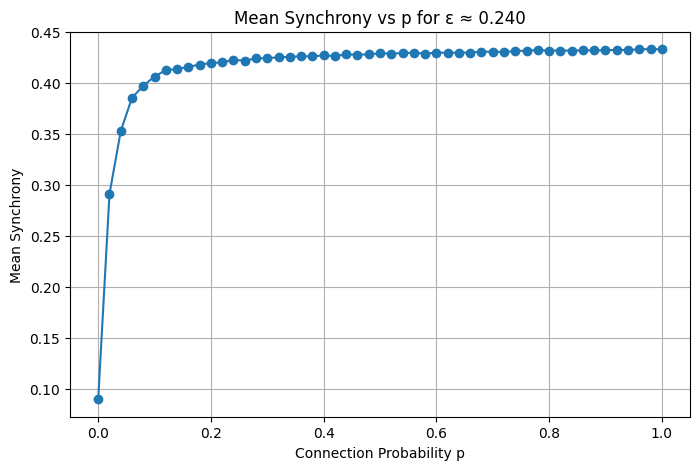

In [ ]:
plot_sync_vs_param("synchrony_data.npz", fixed_value=0.2373, param='epsilon')


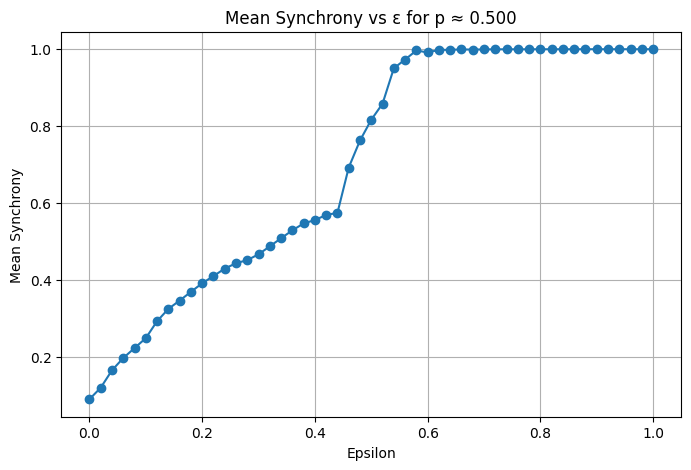

In [ ]:
plot_sync_vs_param("synchrony_data.npz", fixed_value=0.5, param='p')
